In [1]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs


In [7]:
df_ba = pd.read_excel('/Users/enrico/Downloads/Carbonate_measurements2.xlsx', sheet_name='BaCO3 measurements')

df_hr = pd.read_excel('/Users/enrico/Downloads/Carbonate_measurements2.xlsx', sheet_name='Hard rock measurements')



                            OLS Regression Results                            
Dep. Variable:           1000ln_alpha   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     11.08
Date:                Sun, 29 Dec 2024   Prob (F-statistic):             0.0291
Time:                        11:34:08   Log-Likelihood:                -15.077
No. Observations:                   6   AIC:                             34.15
Df Residuals:                       4   BIC:                             33.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3575     10.157     -0.626      0.5

/Users/enrico/.pyenv/versions/3.9.13/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


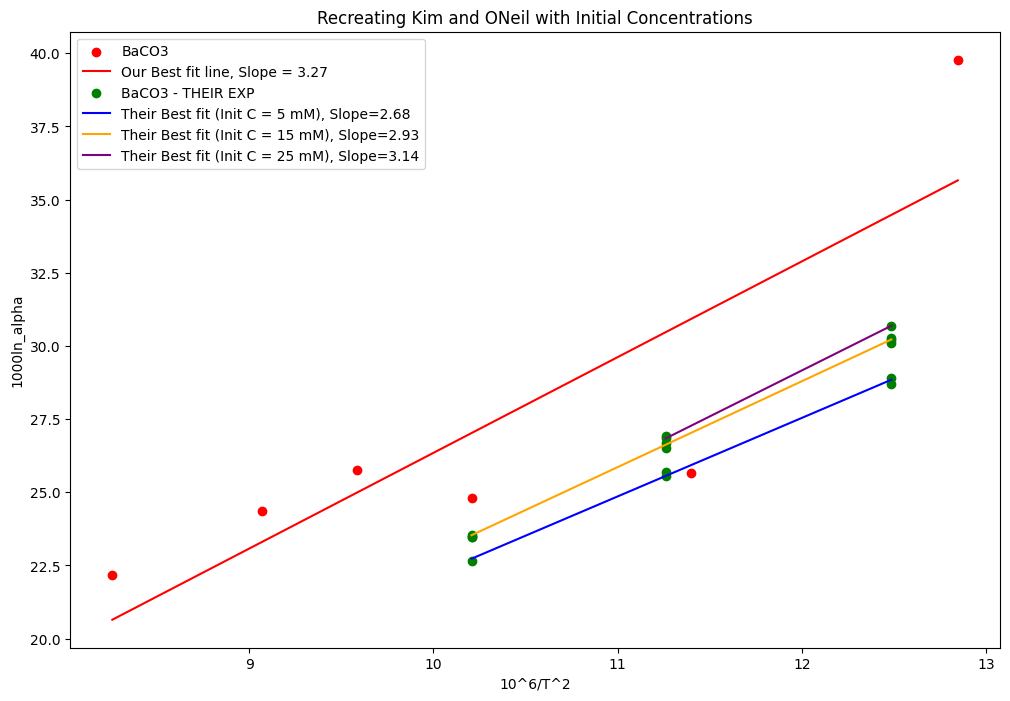

In [21]:
d180_water = -7.56 # SMOW

# plot Temperature against carbonate ox - water ox

# df_ba['Carbonate_ox'] = df_ba['           d18O VPDB']

# # Convert carbonate ox to SMOW
# df_ba['Carbonate_ox'] = df_ba['Carbonate_ox']*1.03092 + 30.92

# df_ba['Carbonate ox - water ox'] = df_ba['Carbonate_ox'] - d180_water

# df_ba carbonate ox - water ox is the same as d18Oc - d18Ow in this scenario



df_ba['1000ln_alpha'] = df_ba['d18Oc - d18Ow']

df_ba['10^6/T^2'] = 10**6/((df_ba['Temperature'] + 273)**2)



# Remove rows with NaN in either x or y
mask = ~np.isnan(df_ba['10^6/T^2']) & ~np.isnan(df_ba['1000ln_alpha'])
y = df_ba.loc[mask, '1000ln_alpha']
x = df_ba.loc[mask, '10^6/T^2']

# Add constant for the intercept
x = sm.add_constant(x)

# Fit the model
model = sm.OLS(y, x).fit()
predictions = model.predict(x)

# Extract the slope
slope1 = model.params['10^6/T^2']

# Print the summary
print(model.summary())


# create a new dataframe with x and y values
# x has valyes of 10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 25, 25, 40, 40 ,40, 40
# y has valyes of 30.69, 30.19, 30.26, 30.09, 28.71, 28.92, 26.84, 26.94, 26.70, 26.50, 25.70, 25.55, 23.47, 23.53, 23.46, 22.66
t_kim = np.array([10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 25, 25, 40, 40 ,40, 40])
ln_kim = np.array([30.69, 30.19, 30.26, 30.09, 28.71, 28.92, 26.84, 26.94, 26.70, 26.50, 25.70, 25.55, 23.47, 23.53, 23.46, 22.66])
init_c_kim = np.array([25,15,15,15,5,5,25,15,15,15,5,5,15,15,15,5])

df_kim = pd.DataFrame({'Temperature': t_kim, '1000ln_alpha': ln_kim})

df_kim['10^6/T^2'] = 10**6/((df_kim['Temperature'] + 273)**2)

# Add initial concentrations to df_kim
df_kim['init_c_kim'] = init_c_kim


fig, ax = plt.subplots(1, 1, figsize=(12, 8))


ax.scatter(df_ba['10^6/T^2'], df_ba['1000ln_alpha'], color='red', label='BaCO3')
# now show best fit line according to model
ax.plot(x['10^6/T^2'], predictions, color='red', label='Our Best fit line, Slope = {:.2f}'.format(slope1))
ax.scatter(df_kim['10^6/T^2'], df_kim['1000ln_alpha'], color='green', label='BaCO3 - THEIR EXP')




# # plot line of y = 2.63x - 4.04
# x = np.linspace(0, 14, 100)
# y = 2.63*x - 4.04
# ax.plot(x, y, color='green', label='y = 2.63x - 4.04')


# Define colors for the groups
colors = {5: 'blue', 15: 'orange', 25: 'purple'}

# Loop over each concentration and fit a model
for concentration in [5, 15, 25]:
    # Filter data
    group = df_kim[df_kim['init_c_kim'] == concentration]
    
    # Get x and y
    x_group = group['10^6/T^2']
    y_group = group['1000ln_alpha']
    
    # Add constant for the intercept
    x_group = sm.add_constant(x_group)
    
    # Fit the model
    model = sm.OLS(y_group, x_group).fit()
    predictions = model.predict(x_group)
    
    # Extract the slope
    slope = model.params['10^6/T^2']
    
    # Plot the best-fit line
    ax.plot(group['10^6/T^2'], predictions, color=colors[concentration], label=f'Their Best fit (Init C = {concentration} mM), ' f"Slope={slope:.2f}")



# Add labels and legend
ax.set_ylabel('1000ln_alpha')
ax.set_xlabel('10^6/T^2')
ax.set_title('Recreating Kim and ONeil with Initial Concentrations')
ax.legend()
plt.show()

In [4]:
# kinetic effects
# difference could be in precipitation rate in terms of how they ppt BaCO3 -> need to look at their paper
# slowly infuse through a membrane


# or
# reaction is exothermic
# at a higher temperature than what we measured it to be